### Goal: track and predict the regions with the highest concentration of viral mosquito vectors

In [26]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

csv_spray = './data/west_nile/input/spray.csv'
csv_train = './data/west_nile/input/train.csv'
csv_test = './data/west_nile/input/test.csv'
csv_weather = './data/west_nile/input/weather.csv'

df_train = pd.read_csv(csv_train)
df_test = pd.read_csv(csv_test)
df_spray = pd.read_csv(csv_spray)
df_weather = pd.read_csv(csv_weather)

#### Visualise the different csv files

In [27]:
df_spray.head(1)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163


In [28]:
df_weather.head(1)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2


In [29]:
df_train.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [30]:
df_test.head(1) ## test data doesnt include "numMosquitos" & "WnvPresent"

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


### EDA

#### Remove data where AddressAccuracy is low

In [31]:
df_train.AddressAccuracy.value_counts() # we define low AddressAccuracy as =<5

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

In [32]:
print('original dataframe:', df_train.shape)
df_train_clean_1 = df_train[df_train.AddressAccuracy > 5]
print('cleaned dataframe:', df_train_clean_1.shape)

original dataframe: (10506, 12)
cleaned dataframe: (8608, 12)


In [33]:
#feature engineering: create columns indicating the month and day from the date columns

# Split station 1 and 2 and join horizontally
weather_stn1 = df_weather[df_weather['Station']==1]
weather_stn2 = df_weather[df_weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
df_weather = weather_stn1.merge(weather_stn2, on='Date')

# replace some missing values and T with -1
df_weather = df_weather.replace('M', -1)
df_weather = df_weather.replace('-', -1)
df_weather = df_weather.replace('T', -1)
df_weather = df_weather.replace(' T', -1)
df_weather = df_weather.replace('  T', -1)

# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_month(x):
    return int(x.split('-')[1])

def create_day(x):
    return int(x.split('-')[2])

def create_year(x):
    return int(x.split('-')[0])

df_train_clean_1['Month'] = df_train_clean_1.Date.apply(create_month)
df_train_clean_1['Day'] = df_train_clean_1.Date.apply(create_day)
df_train_clean_1['Year'] = df_train_clean_1.Date.apply(create_year)

df_test['Month'] = df_test.Date.apply(create_month)
df_test['Day'] = df_test.Date.apply(create_day)
df_test['Year'] = df_test.Date.apply(create_year)

df_weather['month'] = df_weather.Date.apply(create_month)
df_weather['day'] = df_weather.Date.apply(create_day)
df_weather['year'] = df_weather.Date.apply(create_year)

<b> We are interested in amount of rainfall (PrecipTotal), as rainfall creates ideal breeding conditions for mosquitoes. More rain means more potential for puddles, and more potential for mosquito breeding. 
    
Mosquitos are more active at temperatures above 26 deg C, and dormant below temperatures of 10 deg C
    
</b>

In [34]:
df_weather.columns

Index(['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'CodeSum_x',
       'Depth_x', 'Water1_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Tmax_y',
       'Tmin_y', 'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y', 'Heat_y',
       'Cool_y', 'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y', 'Water1_y',
       'SnowFall_y', 'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y',
       'ResultSpeed_y', 'ResultDir_y', 'AvgSpeed_y', 'month', 'day', 'year'],
      dtype='object')

In [35]:
#feature engineering

weather_cols = ['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'CodeSum_x',
       'Depth_x', 'Water1_x', 'SnowFall_x', 'PrecipTotal_x', 'StnPressure_x',
       'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x']

#we are interested in amount of rainfall (PrecipTotal), as rainfall creates ideal breeding conditions for mosquitoes. More rain means more potential for puddles, and more potential for mosquito breeding. 
df_weather_select = df_weather.loc[:,weather_cols]


In [36]:
#we will merge the relevant weather columns (precipitation and average temperature) to create the new features

df_train_clean_1 = df_train_clean_1.merge(df_weather_select, on='Date')

df_test = df_test.merge(df_weather_select, on='Date')

df_train_clean_1

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,CodeSum_x,Depth_x,Water1_x,SnowFall_x,PrecipTotal_x,StnPressure_x,SeaLevel_x,ResultSpeed_x,ResultDir_x,AvgSpeed_x
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,...,BR HZ,0,-1,0.0,0.00,29.39,30.11,5.8,18,6.5


In [37]:
df_train_clean_1.shape

(8608, 35)

In [38]:
df_train_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 0 to 8607
Data columns (total 35 columns):
Date                      8608 non-null object
Address                   8608 non-null object
Species                   8608 non-null object
Block                     8608 non-null int64
Street                    8608 non-null object
Trap                      8608 non-null object
AddressNumberAndStreet    8608 non-null object
Latitude                  8608 non-null float64
Longitude                 8608 non-null float64
AddressAccuracy           8608 non-null int64
NumMosquitos              8608 non-null int64
WnvPresent                8608 non-null int64
Month                     8608 non-null int64
Day                       8608 non-null int64
Year                      8608 non-null int64
Tmax_x                    8608 non-null int64
Tmin_x                    8608 non-null int64
Tavg_x                    8608 non-null object
Depart_x                  8608 non-null object
DewPoin

In [39]:
df_train_clean_1.SnowFall_x.unique()

array(['0.0', -1], dtype=object)

In [40]:
#convert string to integer
df_train_clean_1['Tavg_x']=df_train_clean_1['Tavg_x'].apply(lambda x: int(x))
df_train_clean_1['WetBulb_x']=df_train_clean_1['WetBulb_x'].apply(lambda x: int(x))
df_train_clean_1['Heat_x']=df_train_clean_1['Heat_x'].apply(lambda x: int(x))
df_train_clean_1['Cool_x']=df_train_clean_1['Cool_x'].apply(lambda x: int(x))
df_train_clean_1['PrecipTotal_x']=df_train_clean_1['PrecipTotal_x'].apply(lambda x: float(x))
df_train_clean_1['StnPressure_x']=df_train_clean_1['StnPressure_x'].apply(lambda x: float(x))
df_train_clean_1['SeaLevel_x']=df_train_clean_1['SeaLevel_x'].apply(lambda x: float(x))
df_train_clean_1['AvgSpeed_x']=df_train_clean_1['AvgSpeed_x'].apply(lambda x: float(x))

In [41]:
plt.figure(figsize=(5,12))
#sns.heatmap(df_train_clean_1.corr()[['WnvPresent']].sort_values(by='WnvPresent', ascending=False), annot=True)
df_train_clean_1.corr().abs()[['WnvPresent']].sort_values(by='WnvPresent', ascending=False).head(11)

,WnvPresent
WnvPresent,1.000000
NumMosquitos,0.230154
Month,0.109819
DewPoint_x,0.088573
WetBulb_x,0.076728
Tmin_x,0.073857
Longitude,0.071407
Year,0.069455
Tavg_x,0.067688
Cool_x,0.060550


<Figure size 360x864 with 0 Axes>

In [42]:
df_train_clean_1.drop(['Depart_x','Sunrise_x','Sunset_x','CodeSum_x','Depth_x','SnowFall_x'], axis=1, inplace=True)

In [43]:
# feature engineering: Species
print(df_train_clean_1.Species.value_counts())
df_train_clean_1 = pd.concat([df_train_clean_1, pd.get_dummies(df_train_clean_1.Species)], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test.Species)], axis=1)

CULEX PIPIENS/RESTUANS    4048
CULEX RESTUANS            2393
CULEX PIPIENS             1919
CULEX TERRITANS            172
CULEX SALINARIUS            71
CULEX TARSALIS               4
CULEX ERRATICUS              1
Name: Species, dtype: int64


In [44]:
print(df_train_clean_1.Trap.value_counts().head())
# df_train_clean_1 = pd.concat([df_train_clean_1, pd.get_dummies(df_train_clean_1.Trap)], axis=1)
# df_test = pd.concat([df_test, pd.get_dummies(df_test.Trap)], axis=1)

T900    750
T002    185
T135    183
T054    163
T128    160
Name: Trap, dtype: int64


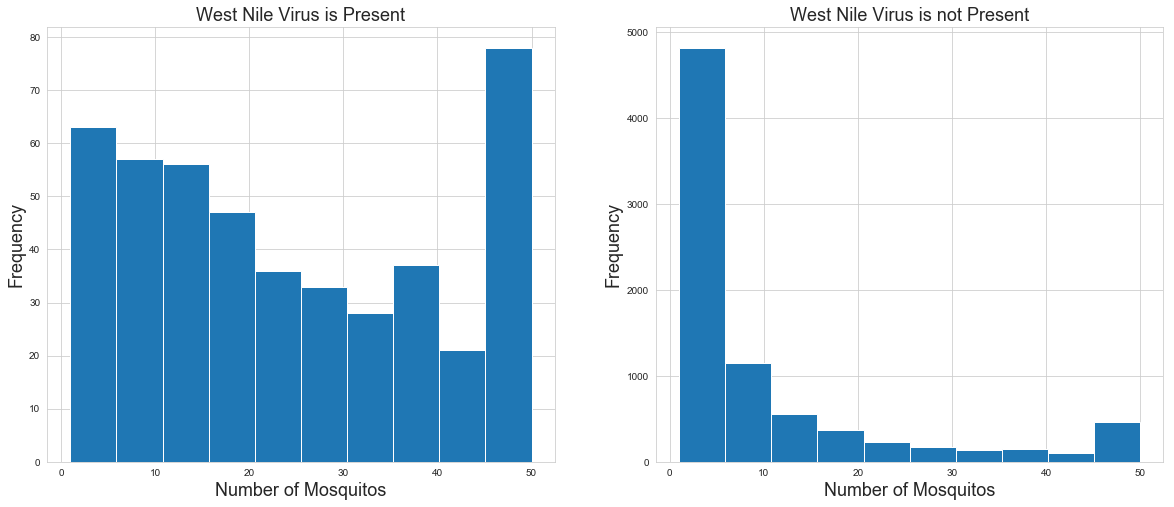

In [45]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes[0].set_xlabel('Number of Mosquitos', fontsize=18)
axes[1].set_xlabel('Number of Mosquitos', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[0].set_title('West Nile Virus is Present', fontsize=18)
axes[1].set_title('West Nile Virus is not Present', fontsize=18)
df_train_clean_1[df_train_clean_1.WnvPresent == 1]['NumMosquitos'].plot(kind='hist', ax = axes[0]);
df_train_clean_1[df_train_clean_1.WnvPresent == 0]['NumMosquitos'].plot(kind='hist', ax = axes[1]);

In [46]:
df_train_clean_1.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,ResultSpeed_x,ResultDir_x,AvgSpeed_x,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,5.8,18,6.5,0,0,1,0,0,0,0


In [47]:
# retrieve data with unique date, long, lat
df_train_clean_2 = df_train_clean_1.groupby(['Date', 'Latitude', 'Longitude']).max().reset_index()
df_train_clean_2.head()

,Date,Latitude,Longitude,Address,Species,Block,Street,Trap,AddressNumberAndStreet,AddressAccuracy,...,ResultSpeed_x,ResultDir_x,AvgSpeed_x,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TARSALIS,CULEX TERRITANS
0,2007-05-29,41.688324,-87.676709,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",8,...,5.8,18,6.5,0,0,1,1,0,0,0
1,2007-05-29,41.720848,-87.666014,"1700 West 95th Street, Chicago, IL 60643, USA",CULEX RESTUANS,17,W 95TH ST,T094,"1700 W 95TH ST, Chicago, IL",9,...,5.8,18,6.5,0,0,0,1,0,0,0
2,2007-05-29,41.731922,-87.677512,"2200 West 89th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 89TH ST,T096,"2200 W 89TH ST, Chicago, IL",8,...,5.8,18,6.5,0,1,0,1,0,0,0
3,2007-05-29,41.732984,-87.649642,"8900 South Carpenter Street, Chicago, IL 60620...",CULEX RESTUANS,89,S CARPENTER ST,T159,"8900 S CARPENTER ST, Chicago, IL",8,...,5.8,18,6.5,0,0,0,1,0,0,0
4,2007-05-29,41.862292,-87.648860,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",8,...,5.8,18,6.5,0,0,0,1,0,0,0


Plot the spray vs locations

In [48]:
df_spray=df_spray[df_spray['Latitude']<42.01743]

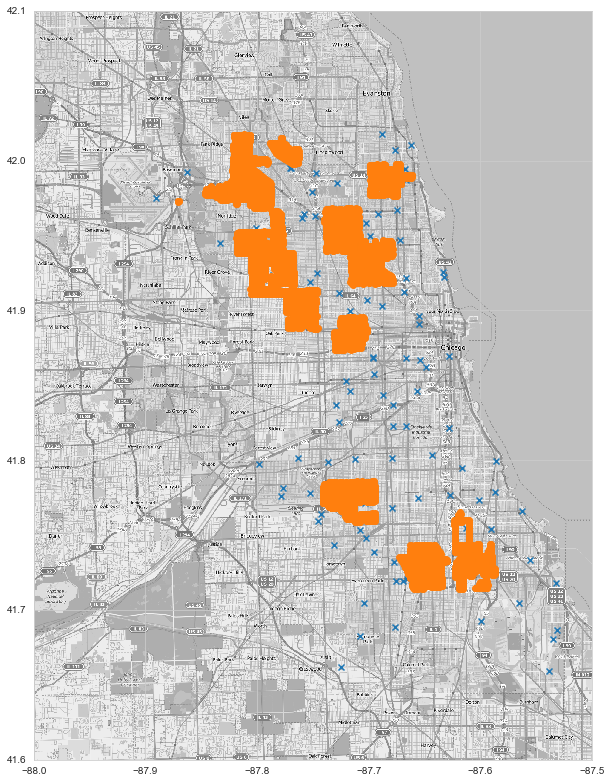

In [49]:
mapdata = np.loadtxt("./data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = df_train_clean_2[['Longitude', 'Latitude']].drop_duplicates().values
spray= df_spray[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(spray[:,0], spray[:,1], marker='o');

In [50]:
def run_pipeline(X, y, desc):   
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
    from sklearn.ensemble import RandomForestClassifier
    X_columns = X.columns
    
    # define models here
    def KNearestNeigbors(X, y, csv_name):
        model_knc = KNeighborsClassifier(n_neighbors=20)
        model_knc.fit(X, y)
        X_test = df_test[X_columns]
        y_predict_tmp = model_knc.predict_proba(X_test)
        y_predict = pd.Series([x[1] for x in y_predict_tmp])
        df_predicted = pd.DataFrame(data = [df_test.Id, y_predict]).T
        df_predicted.Id = df_predicted.Id.map(lambda x:int(x))
        df_predicted = df_predicted.rename(columns={'Unnamed 0':'WnvPresent'})
        df_predicted.set_index('Id').to_csv('KNN_'+csv_name) # Score: 0.54823
        
    def RandomForest(X, y, csv_name):
        model_knc = RandomForestClassifier()
        model_knc.fit(X, y)
        X_test = df_test[X_columns]
        y_predict_tmp = model_knc.predict_proba(X_test)
        y_predict = pd.Series([x[1] for x in y_predict_tmp])
        df_predicted = pd.DataFrame(data = [df_test.Id, y_predict]).T
        df_predicted.Id = df_predicted.Id.map(lambda x:int(x))
        df_predicted = df_predicted.rename(columns={'Unnamed 0':'WnvPresent'})
        df_predicted.set_index('Id').to_csv('RF_'+csv_name) # Score: 0.54823
    
    # Undersampling & Oversampling to solve issue of class imbalance.
    model_undersample = RandomUnderSampler(random_state=42)
    X_undersample, y_undersample = model_undersample.fit_resample(X, y)
    print('Undersampling:', X_undersample.shape, y_undersample.shape)
    KNearestNeigbors(X_undersample, y_undersample, 'undersample_' + desc + '.csv') # 0.56359
    RandomForest(X_undersample, y_undersample, 'undersample_' + desc + '.csv') # 0.56359
    
    model_oversample = RandomOverSampler(random_state=42)
    X_oversample, y_oversample = model_oversample.fit_resample(X,y)
    print('Oversampling:', X_oversample.shape, y_oversample.shape)
    KNearestNeigbors(X_oversample, y_oversample, 'oversample_' + desc + '.csv') # 0.61659
    RandomForest(X_oversample, y_oversample, 'oversample_' + desc + '.csv') # 0.61659
    
    model_ADASYN = ADASYN(random_state=42)
    X_ADASYN, y_ADASYN = model_ADASYN.fit_resample(X,y)
    print('Oversampling ADASYN:', X_ADASYN.shape, y_ADASYN.shape)
    KNearestNeigbors(X_ADASYN, y_ADASYN, 'ADASYN_' + desc + '.csv') # 0.61659
    RandomForest(X_ADASYN, y_ADASYN, 'ADASYN_' + desc + '.csv') # 0.61659
    
    model_SMOTE = SMOTE(random_state=42)
    X_smote, y_smote = model_SMOTE.fit_resample(X,y)
    print('Oversampling SMOTE:', X_smote.shape, y_smote.shape)
    KNearestNeigbors(X_smote, y_smote, 'SMOTE_' + desc + '.csv') # 0.61659
    RandomForest(X_smote, y_smote, 'SMOTE_' + desc + '.csv') # 0.61659

y = df_train_clean_2['WnvPresent'].map(lambda x:1 if x>0 else 0)
print(y.value_counts(),'\n') 

X1 = df_train_clean_2[['Longitude', 'Latitude']]
X2 = df_train_clean_2[['Longitude', 'Latitude', 'Year', 'Month', 'Day']]
run_pipeline(X1, y, 'longlat')
run_pipeline(X2, y, 'date')

0    3689
1     335
Name: WnvPresent, dtype: int64 

Undersampling: (670, 2) (670,)
Oversampling: (7378, 2) (7378,)
Oversampling ADASYN: (7419, 2) (7419,)
Oversampling SMOTE: (7378, 2) (7378,)
Undersampling: (670, 5) (670,)
Oversampling: (7378, 5) (7378,)
Oversampling ADASYN: (7379, 5) (7379,)
Oversampling SMOTE: (7378, 5) (7378,)


In [51]:
X3 = df_train_clean_2[['Longitude', 'Latitude'] + [x for x in df_train_clean_2.columns if x.split(' ')[0] == 'CULEX']]
run_pipeline(X1, y, 'longlatspecies')

Undersampling: (670, 2) (670,)
Oversampling: (7378, 2) (7378,)
Oversampling ADASYN: (7419, 2) (7419,)
Oversampling SMOTE: (7378, 2) (7378,)


In [ ]:
# X4 = df_train_clean_2[['Longitude', 'Latitude'] + [x for x in df_train_clean_2.columns if x.split(' ')[0] == 'TRAP']]
# run_pipeline(X1, y, 'longlattrap') # doesnt really work and is computationally expensive.

In [64]:
columns

['Latitude',
 'Longitude',
 'Species',
 'Block',
 'Street',
 'Trap',
 'AddressNumberAndStreet',
 'AddressAccuracy',
 'NumMosquitos',
 'WnvPresent',
 'Month',
 'Day',
 'Year',
 'Tmax_x',
 'Tmin_x',
 'Tavg_x',
 'DewPoint_x',
 'WetBulb_x',
 'Heat_x',
 'Cool_x',
 'Water1_x',
 'PrecipTotal_x',
 'StnPressure_x',
 'SeaLevel_x',
 'ResultSpeed_x',
 'ResultDir_x',
 'AvgSpeed_x',
 'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS']

In [72]:
columns = list(df_train_clean_2.columns)
columns.remove('Date')
columns.remove('AddressNumberAndStreet')
columns.remove('Block')
columns.remove('Street')
columns.remove('Address')
columns.remove('Trap')
columns.remove('Species')
columns.remove('NumMosquitos')
columns.remove('WnvPresent')

X4 = df_train_clean_2[columns]
print(columns)
run_pipeline(X4, y, 'all')

['Latitude', 'Longitude', 'AddressAccuracy', 'Month', 'Day', 'Year', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Water1_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'CULEX ERRATICUS', 'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS']
Undersampling: (670, 27) (670,)
Oversampling: (7378, 27) (7378,)
Oversampling ADASYN: (7396, 27) (7396,)
Oversampling SMOTE: (7378, 27) (7378,)


In [73]:
columns

['Latitude',
 'Longitude',
 'AddressAccuracy',
 'Month',
 'Day',
 'Year',
 'Tmax_x',
 'Tmin_x',
 'Tavg_x',
 'DewPoint_x',
 'WetBulb_x',
 'Heat_x',
 'Cool_x',
 'Water1_x',
 'PrecipTotal_x',
 'StnPressure_x',
 'SeaLevel_x',
 'ResultSpeed_x',
 'ResultDir_x',
 'AvgSpeed_x',
 'CULEX ERRATICUS',
 'CULEX PIPIENS',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX SALINARIUS',
 'CULEX TARSALIS',
 'CULEX TERRITANS']

In [92]:

# for k in np.linspace(2,len(columns),3):
from sklearn.feature_selection import SelectKBest, f_classif
model_skb = SelectKBest(f_classif, k=5)
X4_new = model_skb.fit_transform(X4, y)
run_pipeline(pd.DataFrame(X4_new, columns=X4.columns [truefalse]), y, 'all_kbest_5')

Undersampling: (670, 5) (670,)
Oversampling: (7378, 5) (7378,)
Oversampling ADASYN: (7406, 5) (7406,)
Oversampling SMOTE: (7378, 5) (7378,)


In [90]:
truefalse = model_skb.get_support()

In [91]:
X4.columns [truefalse]

Index(['Month', 'Tmin_x', 'DewPoint_x', 'WetBulb_x', 'CULEX PIPIENS'], dtype='object')